**<h1> Object detection with Faster R-CNN </h1>**


In [146]:
import torchvision
from torchvision import  transforms 
import torch
from torch import no_grad

libraries for getting data from the web  


In [147]:
import requests

libraries  for image processing and visualization


In [148]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

This function will assign a string name to a predicted class and eliminate predictions whose likelihood  is under a threshold.


In [149]:
def get_predictions(pred,threshold=0.8,objects=None ):
    """
    This function will assign a string name to a predicted class and eliminate predictions whose likelihood  is under a threshold 
    
    pred: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class yhat, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    image : frozen surface
    predicted_classes: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class name, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    thre
    """


    predicted_classes= [(COCO_INSTANCE_CATEGORY_NAMES[i],p,[(box[0], box[1]), (box[2], box[3])]) for i,p,box in zip(list(pred[0]['labels'].numpy()),pred[0]['scores'].detach().numpy(),list(pred[0]['boxes'].detach().numpy()))]
    predicted_classes=[  stuff  for stuff in predicted_classes  if stuff[1]>threshold ]
    
    if objects  and predicted_classes :
        predicted_classes=[ (name, p, box) for name, p, box in predicted_classes if name in  objects ]
    return predicted_classes

Draws box around each object


In [150]:
def draw_box(predicted_classes, image, rect_th=10, text_size=3, text_th=3):
    """
    Draws box around each object.

    predicted_classes: a list where each element contains a tuple that corresponds to information about the different objects;
                        each element includes a tuple with the class name, probability of belonging to that class,
                        and the coordinates of the bounding box corresponding to the object
    image: a frozen surface (tensor-like object with shape [C, H, W])
    """

    # Convert image to numpy array and preprocess
    img = (np.clip(cv2.cvtColor(np.clip(image.numpy().transpose((1, 2, 0)), 0, 1), cv2.COLOR_RGB2BGR), 0, 1) * 255).astype(np.uint8).copy()

    for predicted_class in predicted_classes:
        label = predicted_class[0]
        probability = predicted_class[1]
        box = predicted_class[2]

        # Debugging: print the box coordinates
        print(f"Box coordinates: {box}")

        # Ensure box is in the correct format
        if len(box) != 2 or len(box[0]) != 2 or len(box[1]) != 2:
            raise ValueError(f"Expected bounding box format: ((x1, y1), (x2, y2)). Got: {box}")

        top_left = tuple(map(int, box[0]))  # Ensure coordinates are integers
        bottom_right = tuple(map(int, box[1]))  # Ensure coordinates are integers

        # Debugging: print the processed coordinates
        print(f"Top-left: {top_left}, Bottom-right: {bottom_right}")

        # Draw rectangle
        cv2.rectangle(img, top_left, bottom_right, (0, 255, 0), rect_th)

        # Draw label and probability
        cv2.putText(img, label, top_left, cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)
        cv2.putText(img, f"{label}: {round(probability, 2)}", (top_left[0], top_left[1] + 30), cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)

    # Display the image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide the axes
    plt.show()
    
    # Clean up
    del img
    del image


this function  will speed up your code by freeing memory.


this function will free up some memory:


In [151]:
def save_RAM(image_=False):
    global image, img, pred
    torch.cuda.empty_cache()
    del(img)
    del(pred)
    if image_:
        image.close()
        del(image)

## Load Pre-trained Faster R-CNN


<a href='https://arxiv.org/abs/1506.01497'>Faster R-CNN</a> is a model that predicts both bounding boxes and class scores for potential objects in the image  pre-trained on <a href="https://cocodataset.org/">COCO<a>. 


In [ ]:
model_ = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_.eval()

for name, param in model_.named_parameters():
    param.requires_grad = False
print("done")

the function calls Faster R-CNN <code> model_ </code> but save RAM:


In [153]:
def model(x):
    with torch.no_grad():
        yhat = model_(x)
    return yhat

Here are the 91 classes.


In [154]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
len(COCO_INSTANCE_CATEGORY_NAMES)

91

## Object Localization


In Object Localization we locate the presence of objects in an image and indicate the location with a bounding box. Consider the image of <a href="https://www.utoronto.ca/news/ai-fuels-boom-innovation-investment-and-jobs-canada-report-says"> Geoffrey Hinton</a>


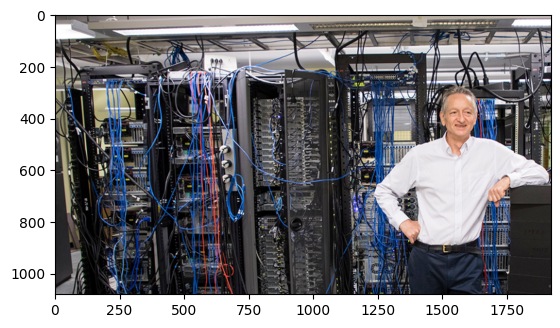

In [155]:
img_path='jeff_hinton.png'
half = 0.5
image = Image.open(img_path)

image.resize( [int(half * s) for s in image.size] )

plt.imshow(image)
plt.show()

We will create a transform object to convert the image to a tensor.


In [156]:
transform = transforms.Compose([transforms.ToTensor()])

We convert the image to a tensor.


In [157]:
img = transform(image)

we can make a prediction,The output is a dictionary with several predicted classes, the probability of belonging to that class and the coordinates of the bounding box corresponding to that class.


In [158]:
pred = model([img])

<b>note</b>:  if you call <code>model_([img])</code>  directly but it will use more RAM 


we have the 35  different class predictions, ordered by likelihood scores for potential objects.


In [159]:
pred[0]['labels']

tensor([ 1, 15, 84,  2, 35, 84, 62,  2,  7, 84, 82, 84, 35, 84,  2, 35, 15, 42,
         2, 82, 62, 84, 62, 84,  7,  2, 84,  7,  2,  9, 84, 84,  2, 84,  2])

We have the likelihood of each class:


In [160]:
pred[0]['scores']

tensor([0.9995, 0.3495, 0.2695, 0.2556, 0.2466, 0.1929, 0.1861, 0.1767, 0.1593,
        0.1528, 0.1484, 0.1392, 0.1295, 0.1290, 0.1249, 0.1208, 0.1094, 0.1026,
        0.1023, 0.1019, 0.0846, 0.0827, 0.0826, 0.0794, 0.0785, 0.0738, 0.0735,
        0.0713, 0.0669, 0.0622, 0.0595, 0.0578, 0.0575, 0.0553, 0.0520])

*Note* here we use likelihood as a synonym for probability. Many neural networks output a probability of the output of being a specific class. Here the output is the confidence of  prediction, so we use the term likelihood to distinguish between the two 


The class number corresponds to the index of the list with the corresponding  category name 


In [161]:
index=pred[0]['labels'][0].item()
COCO_INSTANCE_CATEGORY_NAMES[index]

'person'

we have the coordinates of the bounding box


In [162]:
bounding_box=pred[0]['boxes'][0].tolist()
bounding_box

[1223.1689453125, 301.2501220703125, 1909.172607421875, 1076.63720703125]

These components correspond to the top-left corner and bottom-right corner of the rectangle,more precisely :
<p>top (t),left (l),bottom(b),right (r)</p>
we need to round them


In [163]:
t,l,r,b=[round(x) for x in bounding_box]

We convert the tensor to an open CV array and plot an image with the box:


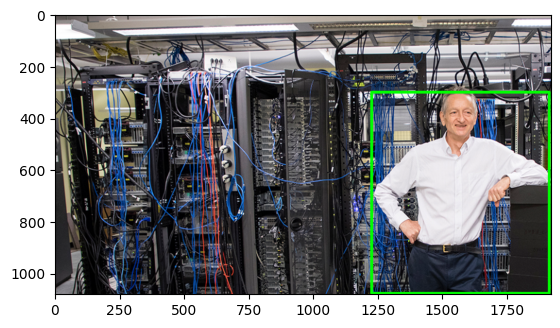

In [164]:
img_plot=(np.clip(cv2.cvtColor(np.clip(img.numpy().transpose((1, 2, 0)),0,1), cv2.COLOR_RGB2BGR),0,1)*255).astype(np.uint8)
cv2.rectangle(img_plot,(t,l),(r,b),(0, 255, 0), 10) # Draw Rectangle with the coordinates
plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
plt.show()
del img_plot, t, l, r, b

We can localize objects; we do this using the function 
<code>get_predictions</code>. The input  is the predictions <code>pred</code> and the <code>objects</code> you would like to localize .


Box coordinates: [(1223.169, 301.25012), (1909.1726, 1076.6372)]
Top-left: (1223, 301), Bottom-right: (1909, 1076)


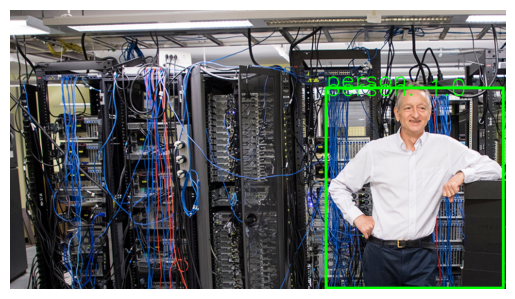

In [165]:
pred_class=get_predictions(pred,objects="person")
draw_box(pred_class, img)
del pred_class

We can set a threshold <code>threshold </code>. Here we set the  threshold 1 i.e Here we set the  threshold 1 i.e. 100% likelihood. 


In [166]:
get_predictions(pred,threshold=1,objects="person")

[]

Here we have no output as the likelihood is not 100%.  Let's try a threshold of 0.98 and use the function  draw_box to draw the box and plot the class and it's rounded likelihood.


Box coordinates: [(1223.169, 301.25012), (1909.1726, 1076.6372)]
Top-left: (1223, 301), Bottom-right: (1909, 1076)


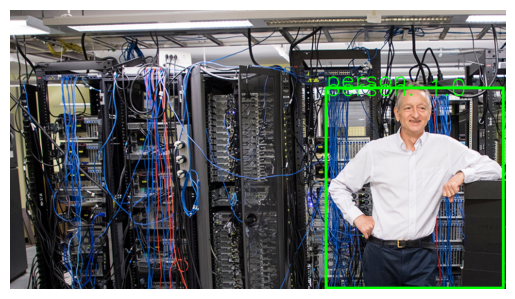

In [167]:
pred_thresh=get_predictions(pred,threshold=0.98,objects="person")
draw_box(pred_thresh,img)
del pred_thresh

Delete objects to save memory, we will run this after every cell:


In [168]:
save_RAM(image_=True)

We can locate multiple objects, consider the following <a href='https://www.kdnuggets.com/2015/03/talking-machine-deep-learning-gurus-p1.html'>image</a>, we can detect the people in the image.


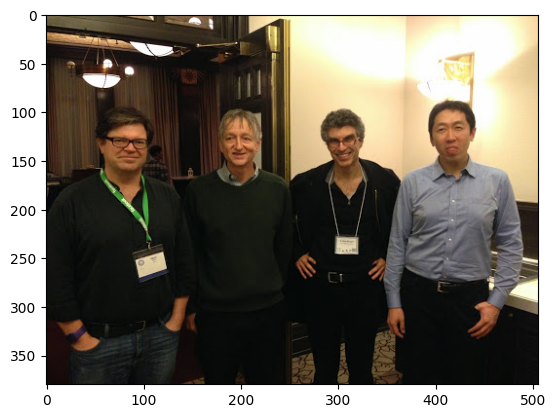

In [169]:
img_path='DLguys.jpeg'
image = Image.open(img_path)
image.resize([int(half * s) for s in image.size])
plt.imshow(np.array(image))
plt.show()

we can set a threshold to detect the object, 0.9 seems to work.


Box coordinates: [(346.55182, 83.92485), (495.25763, 373.51544)]
Top-left: (346, 83), Bottom-right: (495, 373)
Box coordinates: [(249.59798, 96.12699), (364.99664, 374.04578)]
Top-left: (249, 96), Bottom-right: (364, 374)
Box coordinates: [(1.9626213, 94.89626), (150.9305, 369.36908)]
Top-left: (1, 94), Bottom-right: (150, 369)
Box coordinates: [(133.77025, 93.7674), (257.41675, 376.5444)]
Top-left: (133, 93), Bottom-right: (257, 376)


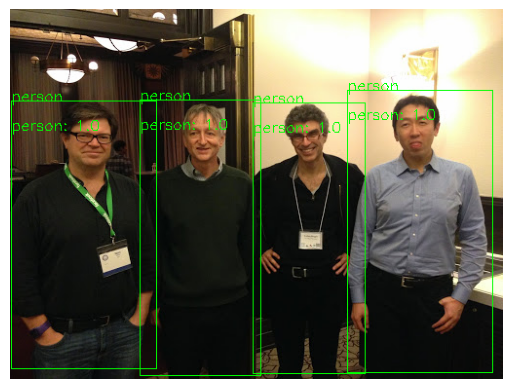

In [170]:
img = transform(image)
pred = model([img])
pred_thresh=get_predictions(pred,threshold=0.8,)
draw_box(pred_thresh,img,rect_th= 1,text_size= 0.5,text_th=1)
del pred_thresh

Or we can use objects parameter: 


Box coordinates: [(346.55182, 83.92485), (495.25763, 373.51544)]
Top-left: (346, 83), Bottom-right: (495, 373)
Box coordinates: [(249.59798, 96.12699), (364.99664, 374.04578)]
Top-left: (249, 96), Bottom-right: (364, 374)
Box coordinates: [(1.9626213, 94.89626), (150.9305, 369.36908)]
Top-left: (1, 94), Bottom-right: (150, 369)
Box coordinates: [(133.77025, 93.7674), (257.41675, 376.5444)]
Top-left: (133, 93), Bottom-right: (257, 376)


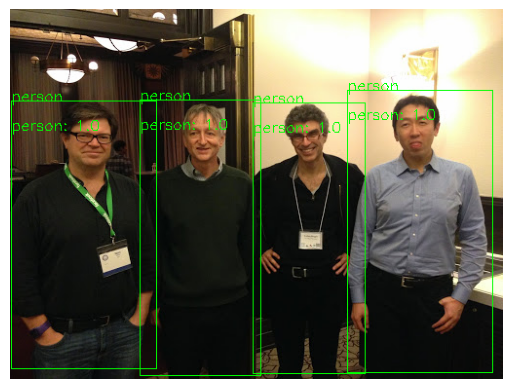

In [171]:
pred_obj=get_predictions(pred,objects="person")
draw_box(pred_obj,img,rect_th= 1,text_size= 0.5,text_th=1)
del pred_obj

If we set the threshold too low, we will detect objects that are not there.


Box coordinates: [(346.55182, 83.92485), (495.25763, 373.51544)]
Top-left: (346, 83), Bottom-right: (495, 373)
Box coordinates: [(249.59798, 96.12699), (364.99664, 374.04578)]
Top-left: (249, 96), Bottom-right: (364, 374)
Box coordinates: [(1.9626213, 94.89626), (150.9305, 369.36908)]
Top-left: (1, 94), Bottom-right: (150, 369)
Box coordinates: [(133.77025, 93.7674), (257.41675, 376.5444)]
Top-left: (133, 93), Bottom-right: (257, 376)
Box coordinates: [(101.20391, 133.92068), (128.84741, 175.09224)]
Top-left: (101, 133), Bottom-right: (128, 175)
Box coordinates: [(104.15061, 134.31575), (123.02897, 155.5695)]
Top-left: (104, 134), Bottom-right: (123, 155)
Box coordinates: [(145.43034, 156.68207), (151.39095, 167.18915)]
Top-left: (145, 156), Bottom-right: (151, 167)
Box coordinates: [(471.9006, 265.5569), (505.30347, 305.92325)]
Top-left: (471, 265), Bottom-right: (505, 305)
Box coordinates: [(57.44711, 161.36382), (128.9634, 290.66647)]
Top-left: (57, 161), Bottom-right: (128, 290)
Bo

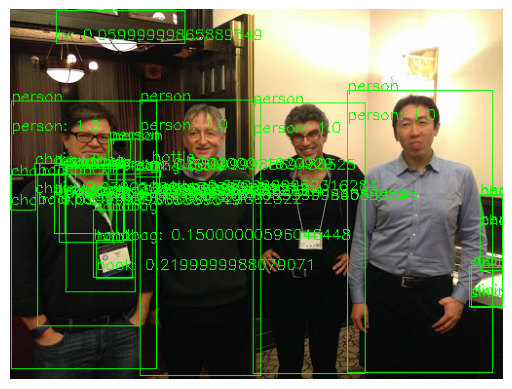

In [172]:
pred_thresh=get_predictions(pred,threshold=0.01)
draw_box(pred_thresh,img,rect_th= 1,text_size= 0.5,text_th=1)
del pred_thresh

the following lines will speed up your code by using less RAM.


In [173]:
save_RAM(image_=True)

## Object Detection 


In Object Detection we find the classes as well detect the objects in an image. Consider the following <a href="https://www.dreamstime.com/stock-image-golden-retriever-puppy-lying-parakeet-perched-its-head-weeks-old-next-to-british-shorthair-kitten-sitting-image30336051">image</a>


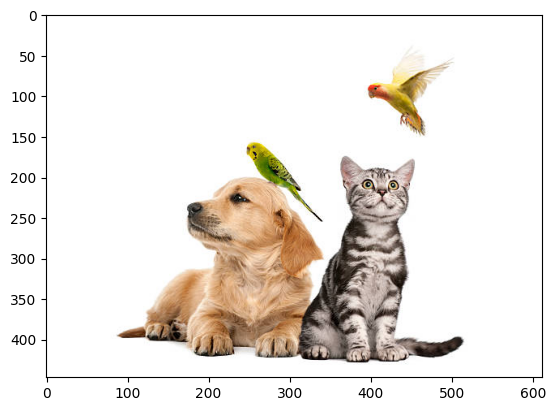

In [174]:
img_path='istockphoto-187786732-612x612.jpeg'
image = Image.open(img_path)
image.resize( [int(half * s) for s in image.size] )
plt.imshow(np.array(image))
plt.show()
del img_path

If we set a threshold, we can detect all objects whose likelihood is above that threshold.


Box coordinates: [(396.1119, 40.974857), (500.29172, 147.12436)]
Top-left: (396, 40), Bottom-right: (500, 147)
Box coordinates: [(298.95926, 167.14587), (459.40622, 437.23874)]
Top-left: (298, 167), Bottom-right: (459, 437)
Box coordinates: [(112.30684, 190.77359), (345.2053, 421.33176)]
Top-left: (112, 190), Bottom-right: (345, 421)
Box coordinates: [(244.24902, 160.39221), (337.39145, 264.01266)]
Top-left: (244, 160), Bottom-right: (337, 264)


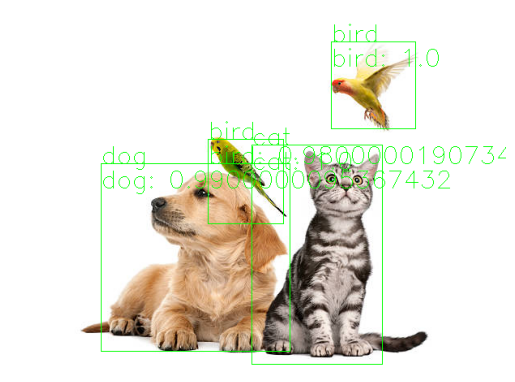

In [175]:
img = transform(image)
pred = model([img])
pred_thresh=get_predictions(pred,threshold=0.97)
draw_box(pred_thresh,img,rect_th= 1,text_size= 1,text_th=1)
del pred_thresh

the following lines will speed up your code by using less RAM.


In [176]:
save_RAM(image_=True)

Box coordinates: [(298.95926, 167.14587), (459.40622, 437.23874)]
Top-left: (298, 167), Bottom-right: (459, 437)
Box coordinates: [(112.30684, 190.77359), (345.2053, 421.33176)]
Top-left: (112, 190), Bottom-right: (345, 421)


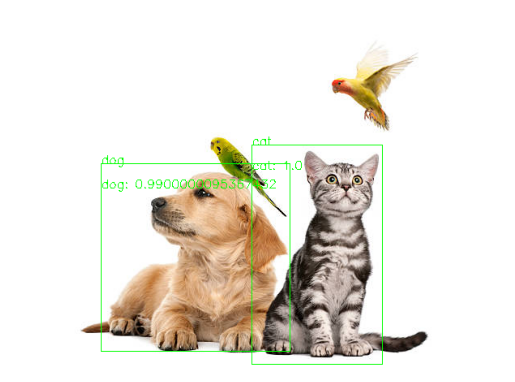

In [177]:
img_path='istockphoto-187786732-612x612.jpeg'
image = Image.open(img_path)
img = transform(image)
pred = model([img])
pred_obj=get_predictions(pred,objects=["dog","cat"])
draw_box(pred_obj,img,rect_th= 1,text_size= 0.5,text_th=1)
del pred_obj



In [178]:
# save_RAM()

If we set the threshold too low, we may detect objects with a low likelihood of being correct; here, we set the threshold to 0.7, and we incorrectly  detect a cat 


Box coordinates: [(298.95926, 167.14587), (459.40622, 437.23874)]
Top-left: (298, 167), Bottom-right: (459, 437)
Box coordinates: [(112.30684, 190.77359), (345.2053, 421.33176)]
Top-left: (112, 190), Bottom-right: (345, 421)
Box coordinates: [(110.79554, 180.83351), (391.58258, 422.93036)]
Top-left: (110, 180), Bottom-right: (391, 422)


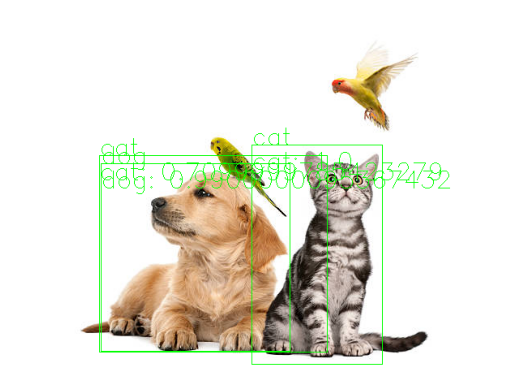

In [179]:
img = transform(image)
pred = model([img])
pred_thresh=get_predictions(pred,threshold=0.70,objects=["dog","cat"])
draw_box(pred_thresh,img,rect_th= 1,text_size= 1,text_th=1)
del pred_thresh

In [180]:
save_RAM(image_=True)


We can detect other objects. Consider the following <a href='https://www.flickr.com/photos/watts_photos/27581126637'>image</a>; We can detect cars and airplanes 


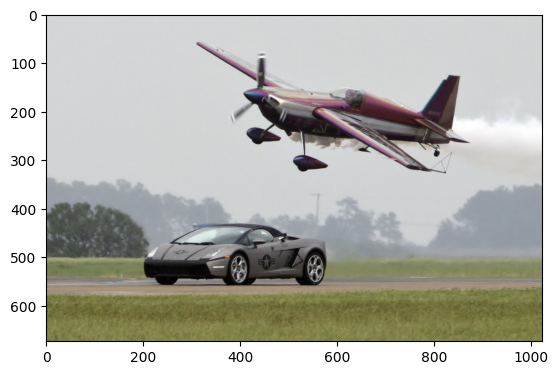

In [181]:
img_path='watts_photos2758112663727581126637_b5d4d192d4_b.jpeg'
image = Image.open(img_path)
image.resize( [int(half * s) for s in image.size] )
plt.imshow(np.array(image))
plt.show()
del img_path

Box coordinates: [(196.52426, 430.0462), (583.29565, 563.4359)]
Top-left: (196, 430), Bottom-right: (583, 563)
Box coordinates: [(311.36395, 70.54165), (868.7393, 313.99115)]
Top-left: (311, 70), Bottom-right: (868, 313)


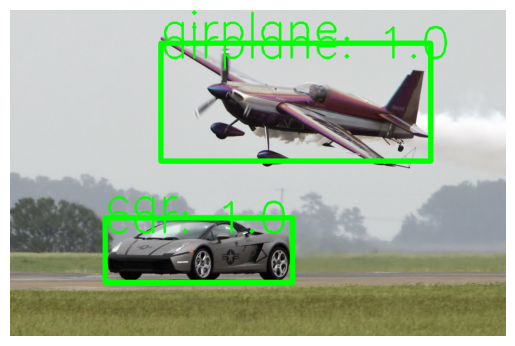

In [182]:
img = transform(image)
pred = model([img])
pred_thresh=get_predictions(pred,threshold=0.997)
draw_box(pred_thresh,img)
del pred_thresh

In [183]:
save_RAM(image_=True)

## Test Model With An Uploaded Image


You can enter the URL of an image and see if you can detect objects in it . Just remember it must have an image  extension like <code>jpg</code> or <code>png</code>.


In [184]:
url = "https://newsroom.porsche.com/.imaging/mte/porsche-templating-theme/image_690x388/dam/pnr/2020/products/Porsche-and-Embraer/Pose1Final.jpeg/jcr:content/Pose1Final.jpeg"

We will perform a get request to download the image from the web and convert it to an RGB image. 


In [185]:
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')
del url

Box coordinates: [(42.365883, 405.43466), (375.9202, 535.7527)]
Top-left: (42, 405), Bottom-right: (375, 535)
Box coordinates: [(488.77234, 275.46622), (1019.7898, 503.44147)]
Top-left: (488, 275), Bottom-right: (1019, 503)


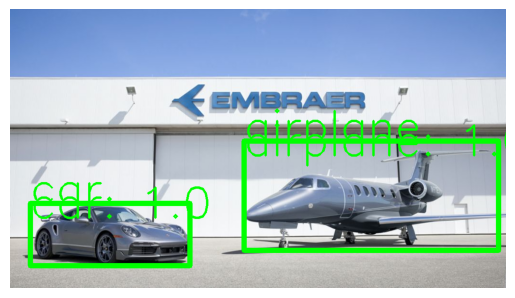

In [186]:
img = transform(image )
pred = model([img])
pred_thresh=get_predictions(pred,threshold=0.95)
draw_box(pred_thresh, img)
del pred_thresh

In [187]:
save_RAM(image_=True)

### Test Model with a Photo from Local

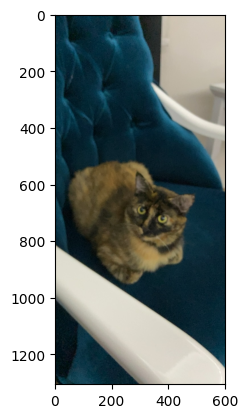

In [188]:
img_path='tarcin.jpeg'
image = Image.open(img_path) # Load the image
plt.imshow(np.array(image ))
plt.show()

Box coordinates: [(45.6766, 516.252), (503.9052, 953.06586)]
Top-left: (45, 516), Bottom-right: (503, 953)


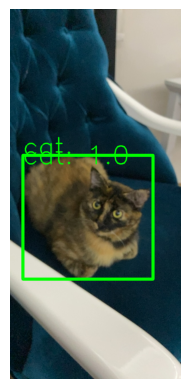

In [189]:
img = transform(image )
pred = model(img.unsqueeze(0))
pred_thresh=get_predictions(pred,threshold=0.95)
draw_box(pred_thresh,img)